In [10]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [11]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [12]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [13]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [14]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [15]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [16]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
0,2021-10-24,48003,Andrews County,TX,39.2,7329,44.6,8349.0
1,2021-10-24,18053,Grant County,IN,38.4,25264,41.4,27205.0
2,2021-10-24,17135,Montgomery County,IL,40.6,11538,51.3,14583.0
3,2021-10-24,21205,Rowan County,KY,47.6,11634,53.0,12964.0
4,2021-10-24,20047,Edwards County,KS,43.3,1211,46.6,1305.0
...,...,...,...,...,...,...,...,...
1037112,2020-12-13,6033,Lake County,CA,0.0,0,0.0,0.0
1037114,2020-12-13,29159,Pettis County,MO,0.0,0,0.0,0.0
1037115,2020-12-13,19087,Henry County,IA,0.0,0,0.0,0.0
1037117,2020-12-13,41011,Coos County,OR,0.0,0,0.0,0.0


<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [17]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [18]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [19]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [20]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

,state,Date,short_staffed,got_covid_at_hosp,total_beds,beds_used,covid_beds_used,icu_occupancy,covid_icu,covid_beds_adult,covid_beds_kids,icu_total,beds_used_pct,covid_patients_pct,covid_beds_pct,icu_used,icu_used_pct,therapy_a,therapy_b,therapy_b
27948,TX,2020-01-01,0.0,0.0,790.0,42.0,0.0,NaN,NaN,NaN,NaN,NaN,0.656250,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
28361,MN,2020-01-01,0.0,0.0,46.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29369,PR,2020-01-01,0.0,0.0,146.0,61.0,0.0,NaN,NaN,NaN,NaN,NaN,0.417808,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
30809,LA,2020-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26436,MT,2020-01-01,0.0,0.0,36.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23141,CT,2021-10-24,0.0,8.0,8456.0,7008.0,260.0,596.0,63.0,259.0,1.0,1024.0,0.828761,0.037486,0.031071,0.062874,0.582031,1939.0,977.0,902.0
16659,GA,2021-10-24,42.0,16.0,23066.0,18316.0,1789.0,2119.0,519.0,1739.0,50.0,2591.0,0.794069,0.098687,0.078592,0.205138,0.817831,10683.0,4585.0,4941.0
14612,OK,2021-10-24,37.0,12.0,10223.0,7329.0,650.0,810.0,203.0,628.0,22.0,946.0,0.716913,0.090203,0.064657,0.225556,0.856237,5218.0,2360.0,2450.0
11554,KY,2021-10-24,51.0,8.0,11859.0,8828.0,1071.0,1222.0,256.0,1026.0,45.0,1406.0,0.744414,0.123259,0.091703,0.188513,0.869132,173.0,62.0,127.0


<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [21]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.0
70.8


,level_0,index,Date,tier,population,total_vaccinated_count,first_dose_count,tot_confirm,tot_death,New_Cases,New_Deaths,case_7_day_avg,death_7_day_avg,case_avg_100k,death_avg_100k,total_vaccinated_percent,first_dose_pct
0,0,0,2020-12-28,total_40,9061156,0,0,610047,7757,7479,92,12295.142857,162.000000,135.690665,1.787851,0.000000,0.000000
1,1,0,2020-12-29,total_40,9061156,0,0,617024,7819,11271,147,12247.571429,164.500000,135.165661,1.815442,0.000000,0.000000
2,2,0,2020-12-30,total_40,9061156,0,0,625042,7900,14995,143,12320.785714,160.357143,135.973663,1.769721,0.000000,0.000000
3,3,0,2020-12-31,total_40,9061156,0,0,632046,8039,15022,220,12324.714286,157.714286,136.017019,1.740554,0.000000,0.000000
4,4,0,2021-01-01,total_40,9061156,0,0,639053,8107,14011,207,12128.357143,157.000000,133.849998,1.732671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0,2021-10-19,total_40,9061156,3909233,4656844,1455702,23860,6929,237,7308.500000,213.142857,80.657479,2.352270,0.431428,0.513935
296,296,0,2021-10-20,total_40,9061156,3913877,4660857,1459368,24012,7250,321,7155.714286,213.642857,78.971318,2.357788,0.431940,0.514378
297,297,0,2021-10-21,total_40,9061156,3918938,4665633,1463516,24084,7814,224,7035.500000,208.428571,77.644618,2.300243,0.432499,0.514905
298,298,0,2021-10-22,total_40,9061156,3927571,4675769,1468110,24193,8742,181,6979.357143,198.714286,77.025019,2.193035,0.433451,0.516023


- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [22]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 54, 56], 'state': ['AL', 'ID', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 28, 29, 30, 38, 40, 45, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MS', 'MO', 'MT', 'ND', 'OK', 'SC', 'TN']}, 50: {'FIPS': [4, 17, 20, 21, 26, 32, 37, 39, 46, 48, 49], 'state': ['AZ', 'IL', 'KS', 'KY', 'MI', 'NV', 'NC', 'OH', 'SD', 'TX', 'UT']}, 55: {'FIPS': [10, 12, 19, 27, 31, 55], 'state': ['DE', 'FL', 'IA', 'MN', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 33, 41, 42, 51, 53], 'state': ['CA', 'CO', 'NH', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 35, 36], 'state': ['MD', 'MA', 'NJ', 'NM', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841,6592849,2021-10-19,13006,712517,3946,12,3105.428571,47.102983,28.571429,0.43337,CT,"[9, 23, 44, 50]",total_70,14609.0,11758.0,617.0,1602.0,0.575353160475673,179.0,610.0,7.0,47.102983,0.43337
3842,6592849,2021-10-20,13020,713895,3330,25,2970.857143,45.061811,23.000000,0.348863,CT,"[9, 23, 44, 50]",total_70,15435.0,12533.0,633.0,1623.0,0.570028330862422,176.0,620.0,13.0,45.061811,0.348863
3843,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12534.0,607.0,1621.0,0.5668881478873999,179.0,597.0,10.0,42.955633,0.244854
3844,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15496.0,12529.0,620.0,1623.0,0.473406193170608,157.0,609.0,11.0,41.380333,0.249188


<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [23]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count,tier
334,2020-12-21,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,779,14,14,1,36.142857,0.571429,67.087755,1.060676,67.087755,1.060676,0.0,0,0.0,0.0,total_0
335,2020-12-22,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,805,14,30,0,34.142857,0.571429,63.375389,1.060676,63.375389,1.060676,0.0,0,0.0,0.0,total_0
336,2020-12-23,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,825,15,46,1,36.285714,0.714286,67.352924,1.325845,67.352924,1.325845,0.0,0,0.0,0.0,total_0
337,2020-12-24,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,841,16,36,2,37.000000,1.000000,68.678769,1.856183,68.678769,1.856183,0.0,0,0.0,0.0,total_0
338,2020-12-25,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,860,16,35,1,37.285714,1.000000,69.209107,1.856183,69.209107,1.856183,0.0,0,0.0,0.0,total_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-10-19,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20329,521,173,2,132.857143,0.714286,161.481322,0.868179,100,0.868179,100,108740,100,121351.0,total_95
637,2021-10-20,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20426,522,131,2,114.571429,0.857143,139.255936,1.041815,100,1.041815,100,108832,100,121510.0,total_95
638,2021-10-21,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20535,523,206,2,116.857143,1.000000,142.034109,1.215451,100,1.215451,100,109059,100,121719.0,total_95
639,2021-10-22,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20589,523,163,1,121.428571,1.142857,147.590456,1.389087,100,1.389087,100,109284,100,121987.0,total_95


In [24]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
16,2020-02-07,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
17,2020-02-08,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
18,2020-02-09,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
19,2020-02-10,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-10-19,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20329,521,173,2,132.857143,0.714286,161.481322,0.868179,100,0.868179,total_95
637,2021-10-20,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20426,522,131,2,114.571429,0.857143,139.255936,1.041815,100,1.041815,total_95
638,2021-10-21,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20535,523,206,2,116.857143,1.000000,142.034109,1.215451,100,1.215451,total_95
639,2021-10-22,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20589,523,163,1,121.428571,1.142857,147.590456,1.389087,100,1.389087,total_95


- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [25]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
6     10203.949731
7     10964.214197
8     10593.993455
9     10858.676647
10    10316.309802
11     9708.042012
12    10118.705763
13     9794.508513
14     8151.010218
Name: confirm_period_100k, dtype: float64
26    4744.247126
27    5169.336670
28    4864.710006
29    3953.907015
30    3934.436603
31    3135.682791
32    2681.595560
33    1921.259540
34    1907.605665
Name: confirm_period_100k, dtype: float64

6     1.000000
7     1.074507
8     1.038225
9     1.064164
10    1.011011
11    0.951400
12    0.991646
13    0.959874
14    0.798809
Name: confirm_period_100k, dtype: float64
26    1.000000
27    1.089601
28    1.025391
29    0.833411
30    0.829307
31    0.660944
32    0.565231
33    0.404966
34    0.402088
Name: confirm_period_100k, dtype: float64
[ 0.         -0.01509417  0.01283342  0.23075322  0.18170459  0.29045618
  0.42641498  0.55490808  0.39672115]
6     193.199296
7     210.322544
8     193.131351
9     193.487977
10    158.259678
11    167.

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
6,0,total_30,start,9917738,0.030423,2020-02-06,2021-06-30,1012001,10203.949731,19161,193.199296
7,0,total_35,start,17855908,0.054773,2020-02-06,2021-06-30,1957760,10964.214197,37555,210.322544
8,0,total_40,start,25599676,0.078527,2020-02-06,2021-06-30,2712028,10593.993455,49441,193.131351
9,0,total_45,start,43134980,0.132317,2020-02-06,2021-06-30,4683888,10858.676647,83461,193.487977
10,0,total_50,start,53637794,0.164534,2020-02-06,2021-06-30,5533441,10316.309802,84887,158.259678
11,0,total_55,start,63156484,0.193733,2020-02-06,2021-06-30,6131258,9708.042012,105477,167.008980
12,0,total_60,start,58249910,0.178682,2020-02-06,2021-06-30,5894137,10118.705763,111872,192.055232
13,0,total_65,start,19572733,0.060039,2020-02-06,2021-06-30,1917053,9794.508513,37385,191.005518
14,0,total_70,start,18430329,0.056535,2020-02-06,2021-06-30,1502258,8151.010218,33173,179.991361


In [26]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
6,0,total_30,start,9917738,0.030423,2020-02-06,2021-06-30,1012001,10203.949731,19161,193.199296
7,0,total_35,start,17855908,0.054773,2020-02-06,2021-06-30,1957760,10964.214197,37555,210.322544
8,0,total_40,start,25599676,0.078527,2020-02-06,2021-06-30,2712028,10593.993455,49441,193.131351
9,0,total_45,start,43134980,0.132317,2020-02-06,2021-06-30,4683888,10858.676647,83461,193.487977
10,0,total_50,start,53637794,0.164534,2020-02-06,2021-06-30,5533441,10316.309802,84887,158.259678
11,0,total_55,start,63156484,0.193733,2020-02-06,2021-06-30,6131258,9708.042012,105477,167.008980
12,0,total_60,start,58249910,0.178682,2020-02-06,2021-06-30,5894137,10118.705763,111872,192.055232
13,0,total_65,start,19572733,0.060039,2020-02-06,2021-06-30,1917053,9794.508513,37385,191.005518
14,0,total_70,start,18430329,0.056535,2020-02-06,2021-06-30,1502258,8151.010218,33173,179.991361


In [27]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
1148,2021-10-24,35031,McKinley County,NM,99.9,72289,99.9,80176.0
6542,2021-10-23,35031,McKinley County,NM,99.9,72213,99.9,80055.0
6569,2021-10-22,35031,McKinley County,NM,99.9,72140,99.9,79946.0
11549,2021-10-21,35031,McKinley County,NM,99.9,72020,99.9,79747.0
13889,2021-10-20,35031,McKinley County,NM,99.9,71941,99.9,79619.0
...,...,...,...,...,...,...,...,...
1022667,2020-12-17,35031,McKinley County,NM,0.0,0,0.0,0.0
1027401,2020-12-16,35031,McKinley County,NM,0.0,0,0.0,0.0
1028541,2020-12-15,35031,McKinley County,NM,0.0,0,0.0,0.0
1031673,2020-12-14,35031,McKinley County,NM,0.0,0,0.0,0.0


# Build Statewide Overview Summary Dictionary #

In [28]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-23 00:00:00'),
  'confirm_period': 860606,
  'confirm_start': 610047,
  'confirm_end': 1470653,
  'confirm_period_100k': 9497.75061813305,
  'confirm_deaths': 16474,
  'death_period_100k': 181.80903187187155,
  'vax_complete': 3935199,
  'vax_complete_100k': 43429.32623607849,
  'vax_partial': 4682225,
  'vax_partial_100k': 51673.59440671808,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 51895516,
  'pop_pct': 0.1586152982715515,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-23 00:00:00'),
  'confirm_period': 4732252,
  'confirm_start': 3575088,
  'confirm_end': 8307340,
  'confirm_period_100k': 9118.807104644648,
  'confirm_deaths': 76482,
  'death_period_100k': 147.37689475907706,
  'vax_complete': 25019645,
  'vax_complete_100k': 48211.57380918999,
 

# Statewide Vax Tier Graphs #

In [29]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0277 confirm 100k:9497 Death 100k:181 Vaccine 100k:43429
total_45 pop pct:0.1586 confirm 100k:9118 Death 100k:147 Vaccine 100k:48211
total_50 pop pct:0.2924 confirm 100k:7884 Death 100k:119 Vaccine 100k:52927
total_55 pop pct:0.1192 confirm 100k:9020 Death 100k:71 Vaccine 100k:58625
total_60 pop pct:0.2494 confirm 100k:6700 Death 100k:106 Vaccine 100k:60735
total_65 pop pct:0.1527 confirm 100k:7179 Death 100k:95 Vaccine 100k:66987


# Build Statewide Overview Summer Summary Dictionary #

In [30]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-23 00:00:00'),
  'confirm_period': 792080,
  'confirm_start': 678573,
  'confirm_end': 1470653,
  'confirm_period_100k': 8741.489496483671,
  'confirm_deaths': 15627,
  'death_period_100k': 172.46143869501861,
  'vax_complete': 3935199,
  'vax_complete_100k': 43429.32623607849,
  'vax_partial': 4682225,
  'vax_partial_100k': 51673.59440671808,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 51895516,
  'pop_pct': 0.1586152982715515,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-23 00:00:00'),
  'confirm_period': 4321794,
  'confirm_start': 3985546,
  'confirm_end': 8307340,
  'confirm_period_100k': 8327.87557213999,
  'confirm_deaths': 71323,
  'death_period_100k': 137.43576612669196,
  'vax_complete': 25019645,
  'vax_complete_100k': 48211.57380918999,
 

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [31]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

,tier,period,population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,total_40,start,9061156,0.027847,2020-02-07,2021-06-30,972312,10730.551378,17142,189.181160
0,total_45,start,51895516,0.159489,2020-02-07,2021-06-30,5767508,11113.692366,100894,194.417568
0,total_50,start,95662220,0.293996,2020-02-07,2021-06-30,9940505,10391.254771,170018,177.727425
0,total_55,start,39003045,0.119867,2020-02-07,2021-06-30,4356544,11169.753541,62757,160.902822
0,total_60,start,79800808,0.245249,2020-02-07,2021-06-30,7086799,8880.610582,119120,149.271672
0,total_65,start,43370763,0.133290,2020-02-07,2021-06-30,4513233,10406.164632,111952,258.127808
0,total_70,start,6592849,0.020262,2020-02-07,2021-06-30,595409,9031.133581,12111,183.699035
0,total_40,summer,9061156,0.027847,2021-07-01,2021-10-23,498131,5497.433219,7081,78.146762
0,total_45,summer,51895516,0.159489,2021-07-01,2021-10-23,2535447,4885.676443,31857,61.386807
0,total_50,summer,95662220,0.293996,2021-07-01,2021-10-23,3444142,3600.315778,38963,40.729768


In [32]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
6     10203.949731
7     10964.214197
8     10593.993455
9     10858.676647
10    10316.309802
11     9708.042012
12    10118.705763
13     9794.508513
14     8151.010218
Name: confirm_period_100k, dtype: float64
26    4744.247126
27    5169.336670
28    4864.710006
29    3953.907015
30    3934.436603
31    3135.682791
32    2681.595560
33    1921.259540
34    1907.605665
Name: confirm_period_100k, dtype: float64
0    0.464942
1    0.471474
2    0.459195
3    0.364124
4    0.381380
5    0.322998
6    0.265014
7    0.196157
8    0.234033
dtype: float64
0    0.344919
1    0.328372
2    0.309015
3    0.224668
4    0.202045
5    0.140049
6    0.096628
7    0.068610
8    0.065023
dtype: float64



In [33]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [34]:
county_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
6,0,total_30,start,9917738,0.030480,2020-02-06,2021-06-30,1012001,10203.949731,19161,193.199296
7,0,total_35,start,17855908,0.054876,2020-02-06,2021-06-30,1957760,10964.214197,37555,210.322544
8,0,total_40,start,25599676,0.078675,2020-02-06,2021-06-30,2712028,10593.993455,49441,193.131351
9,0,total_45,start,43134980,0.132565,2020-02-06,2021-06-30,4683888,10858.676647,83461,193.487977
10,0,total_50,start,53637794,0.164843,2020-02-06,2021-06-30,5533441,10316.309802,84887,158.259678
11,0,total_55,start,63156484,0.194097,2020-02-06,2021-06-30,6131258,9708.042012,105477,167.008980
12,0,total_60,start,58249910,0.179018,2020-02-06,2021-06-30,5894137,10118.705763,111872,192.055232
13,0,total_65,start,19572733,0.060152,2020-02-06,2021-06-30,1917053,9794.508513,37385,191.005518
14,0,total_70,start,18430329,0.056641,2020-02-06,2021-06-30,1502258,8151.010218,33173,179.991361
26,0,total_30,summer,9917738,0.030480,2021-07-01,2021-10-23,470522,4744.247126,6609,66.638179


In [35]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
313        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
312        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
311        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
310        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
309        1      1  Alabama  POLYGON ((-88.46866 31.89

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

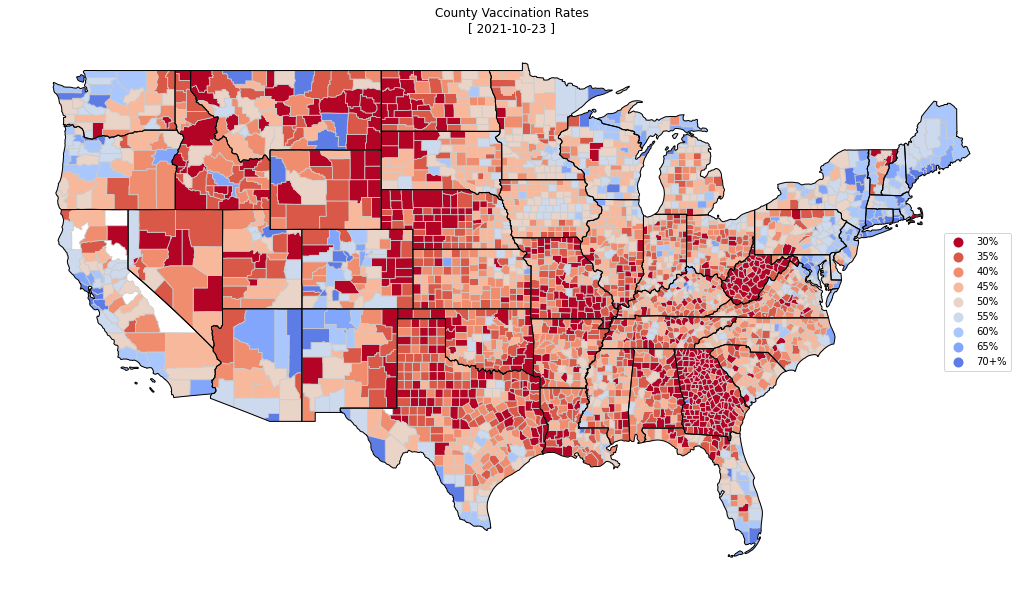

In [38]:
plot_df = geo_county_tier_df.copy()



#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


#outfilename=f'z_blog_natl_county_vax.jpg'
#out_blog_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")





In [39]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
6,0,total_30,start,9917738,0.030480,2020-02-06,2021-06-30,1012001,10203.949731,19161,193.199296
7,0,total_35,start,17855908,0.054876,2020-02-06,2021-06-30,1957760,10964.214197,37555,210.322544
8,0,total_40,start,25599676,0.078675,2020-02-06,2021-06-30,2712028,10593.993455,49441,193.131351
9,0,total_45,start,43134980,0.132565,2020-02-06,2021-06-30,4683888,10858.676647,83461,193.487977
10,0,total_50,start,53637794,0.164843,2020-02-06,2021-06-30,5533441,10316.309802,84887,158.259678
11,0,total_55,start,63156484,0.194097,2020-02-06,2021-06-30,6131258,9708.042012,105477,167.008980
12,0,total_60,start,58249910,0.179018,2020-02-06,2021-06-30,5894137,10118.705763,111872,192.055232
13,0,total_65,start,19572733,0.060152,2020-02-06,2021-06-30,1917053,9794.508513,37385,191.005518
14,0,total_70,start,18430329,0.056641,2020-02-06,2021-06-30,1502258,8151.010218,33173,179.991361


In [40]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 114


{'start_daily_100k_confirm': 6     10203
 7     10964
 8     10593
 9     10858
 10    10316
 11     9708
 12    10118
 13     9794
 14     8151
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8151,
 'start_daily_100k_confirm_max': 10964,
 'start_daily_mean_confirm': 6      1980.432485
 7      3831.232877
 8      5307.295499
 9      9166.121331
 10    10828.651663
 11    11998.547945
 12    11534.514677
 13     3751.571429
 14     2939.839530
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 26     4127.385965
 27     8096.771930
 28    10924.122807
 29    14960.675439
 30    18511.798246
 31    17371.815789
 32    13701.991228
 33     3298.622807
 34     3084.017544
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 6      37.497065
 7      73.493151
 8      96.753425
 9     163.328767
 10    166.119374
 11    206.412916
 12    218.927593
 13     73.160470
 14     64.917808
 Name: confirm_deaths, dtype: float64,
 'summer_dai

In [41]:
county_analysis_dict

{'start_daily_100k_confirm': 6     10203
 7     10964
 8     10593
 9     10858
 10    10316
 11     9708
 12    10118
 13     9794
 14     8151
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8151,
 'start_daily_100k_confirm_max': 10964,
 'start_daily_mean_confirm': 6      1980.432485
 7      3831.232877
 8      5307.295499
 9      9166.121331
 10    10828.651663
 11    11998.547945
 12    11534.514677
 13     3751.571429
 14     2939.839530
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 26     4127.385965
 27     8096.771930
 28    10924.122807
 29    14960.675439
 30    18511.798246
 31    17371.815789
 32    13701.991228
 33     3298.622807
 34     3084.017544
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 6      37.497065
 7      73.493151
 8      96.753425
 9     163.328767
 10    166.119374
 11    206.412916
 12    218.927593
 13     73.160470
 14     64.917808
 Name: confirm_deaths, dtype: float64,
 'summer_dai

In [42]:
state_hosp_tiers_df

,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841,6592849,2021-10-19,13006,712517,3946,12,3105.428571,47.102983,28.571429,0.43337,CT,"[9, 23, 44, 50]",total_70,14609.0,11758.0,617.0,1602.0,0.575353160475673,179.0,610.0,7.0,47.102983,0.43337
3842,6592849,2021-10-20,13020,713895,3330,25,2970.857143,45.061811,23.000000,0.348863,CT,"[9, 23, 44, 50]",total_70,15435.0,12533.0,633.0,1623.0,0.570028330862422,176.0,620.0,13.0,45.061811,0.348863
3843,6592849,2021-10-21,13026,715474,2957,20,2832.000000,42.955633,16.142857,0.244854,CT,"[9, 23, 44, 50]",total_70,15434.0,12534.0,607.0,1621.0,0.5668881478873999,179.0,597.0,10.0,42.955633,0.244854
3844,6592849,2021-10-22,13050,716926,3031,30,2728.142857,41.380333,16.428571,0.249188,CT,"[9, 23, 44, 50]",total_70,15496.0,12529.0,620.0,1623.0,0.473406193170608,157.0,609.0,11.0,41.380333,0.249188


In [43]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

,Date,Location,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct
20125,2020-12-13,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20084,2020-12-14,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20039,2020-12-15,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
19982,2020-12-16,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
19901,2020-12-17,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-10-20,US,219381466,66.1,219147468,77.3,204312567,79.1,52458039,95.9,189709710,57.1,189576681,66.9,177262850,68.6,46202561,84.5
241,2021-10-21,US,219624445,66.2,219390343,77.4,204534420,79.2,52509902,96.0,189924447,57.2,189791361,66.9,177453836,68.7,46229324,84.5
160,2021-10-22,US,219900525,66.2,219666287,77.5,204788212,79.3,52572844,96.1,190179553,57.3,190046408,67.0,177683586,68.8,46264299,84.6
88,2021-10-23,US,220145796,66.3,219911449,77.6,205012732,79.4,52627847,96.2,190402262,57.4,190269066,67.1,177883133,68.9,46294318,84.6


- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [44]:
"""#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                continue

                
        fig, ax = plt.subplots()

        fig.set_size_inches(10,5)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 70})

        plt.close()
        
    
    

    print("Done...")
"""
print()

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [58]:
county_daily_df = pd.read_pickle(county_daily_df_filename)
county_vax_df
county_daily_df = county_daily_df[county_daily_df['Population'] > 0]
county_daily_df
county_vax_df


whole_county_tier_df

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
16,2020-02-07,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
17,2020-02-08,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
18,2020-02-09,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
19,2020-02-10,"[54017, 25007, 25019, 54091]",Dukes,Massachusetts,"Dukes, Massachusetts, US",53874,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-10-19,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20329,521,173,2,132.857143,0.714286,161.481322,0.868179,100,0.868179,total_95
637,2021-10-20,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20426,522,131,2,114.571429,0.857143,139.255936,1.041815,100,1.041815,total_95
638,2021-10-21,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20535,523,206,2,116.857143,1.000000,142.034109,1.215451,100,1.215451,total_95
639,2021-10-22,"[13053, 35031]",Chattahoochee,Georgia,"Chattahoochee, Georgia, US",82274,20589,523,163,1,121.428571,1.142857,147.590456,1.389087,100,1.389087,total_95


In [59]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [90]:
#//*** Get Tiers with less than 2.5% of US POPULATION and assimlliate them into the highest and lowest toers

last_day_df = whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()]
us_pop = last_day_df['Population'].sum()
lo_vals = last_day_df[last_day_df['Population'] < us_pop * .025]['tier'].str.replace("total_","").astype(int)
lo_vals = list("total_" + lo_vals[lo_vals < 50].astype(str))
hi_vals = last_day_df[last_day_df['Population'] < us_pop * .025]['tier'].str.replace("total_","").astype(int)
hi_vals = list("total_" + hi_vals[hi_vals > 50].astype(str))
lo_assim = -1
hi_assim = -1
for i in range(len(whole_county_tier_df['tier'].unique())):
    if lo_vals[-1] == whole_county_tier_df['tier'].unique()[i]:
        lo_assim = whole_county_tier_df['tier'].unique()[i+1]
    if hi_vals[0] == whole_county_tier_df['tier'].unique()[i]:
        hi_assim = whole_county_tier_df['tier'].unique()[i-1]
    
print(lo_assim,hi_assim)

working_county_tier = whole_county_tier_df.copy()
for val in lo_vals:
    working_county_tier['tier'] = working_county_tier['tier'].str.replace(val,lo_assim)

for val in hi_vals:
    working_county_tier['tier'] = working_county_tier['tier'].str.replace(val,hi_assim)
    
for date in working_county_tier['Date'].unique():
    
    for tier in ['total_30']:
        loop_df = working_county_tier[(working_county_tier['tier']==tier) & (working_county_tier['Date'] <= date)]
        loop_series = pd.Series()
        loop_series['Date'] = date
        loop_series['FIPS'] = loop_df['FIPS'].unique()[0]
        loop_series['tier'] = tier
    

total_30 total_70
          Date                                               FIPS   Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
15  2020-02-06  [54087, 54105, 25001, 13183, 54097, 54001, 540...     Long        Georgia         Long, Georgia, US     366631           0          0           0          0             0.0   
15  2020-02-06  [13125, 13281, 38087, 13049, 13023, 13227, 130...  Appling        Georgia      Appling, Georgia, US     910430           0          0           0          0             0.0   
15  2020-02-06  [13247, 13167, 13249, 48165, 13081, 1133, 1304...  Winston        Alabama      Winston, Alabama, US    1493028           0          0           0          0             0.0   
15  2020-02-06  [29145

          Date                                               FIPS   Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
16  2020-02-07                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
17  2020-02-08                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
18  2020-02-09                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
19  2020-02-10                       [54

          Date                                               FIPS   Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
16  2020-02-07                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
17  2020-02-08                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
18  2020-02-09                       [54017, 25007, 25019, 54091]    Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
19  2020-02-10                       [54

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
19  2020-02-10                       [54017, 25007

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0             0.0   
19  2020-02-10                       [54017, 25007

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19  2020-02-10                       [54017, 25007

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19  2020-02-10                       [54017, 25007

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19  2020-02-10                       [54017, 25007

          Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15  2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16  2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17  2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18  2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19  2020-02-10                       [54017, 25007

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

           Date                                               FIPS Admin2 Province_State              Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
16   2020-02-07                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
17   2020-02-08                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
18   2020-02-09                       [54017, 25007, 25019, 54091]  Dukes  Massachusetts  Dukes, Massachusetts, US      53874           0          0           0          0        0.000000   
19   2020-02-10                       [54017,

In [ ]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [ ]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [ ]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

In [ ]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [ ]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [ ]:
#//**** Build slideshow HTML
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"




In [ ]:
#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers

In [ ]:
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

In [ ]:
plot_df